<a href="https://colab.research.google.com/github/DimitrisLianos/DL/blob/main/test_gan_sm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Import the libraries
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras import layers
import time
from IPython import display
tf.__version__
class cfg:
    BATCH_SIZE = 64
    EPOCHS = 200
    NOISE_DIM = 250
    NUM_EXAMPLES_TO_GENERATE = 16
dirs = ['neutral', 'fear', 'angry', 'surprise', 'disgust']
train_images = []

In [ ]:
# Other utilities
import os
import cv2
!pip install rarfile
from rarfile import RarFile

# Assign main directory to a variable
#main_dir=os.path.dirname(os.path.abspath('__file__'))

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Extract .rar file
with RarFile('/content/drive/MyDrive/Colab Notebooks/GAN face generation model with sentiment parameters/train.rar', 'r') as rar_ref:
    rar_ref.extractall('/content/train')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for folder in dirs:
    directory = '/content/train/train/{}/'.format(folder)
    for image_name in os.listdir(directory):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(directory, image_name)
            image = cv2.imread(image_path, 0)
            image = np.expand_dims(image, 2)
            image = (image - 127.5)/127.5
            train_images.append(image)
        
dataset = tf.data.Dataset.from_tensor_slices(train_images)
dataset = dataset.batch(cfg.BATCH_SIZE)

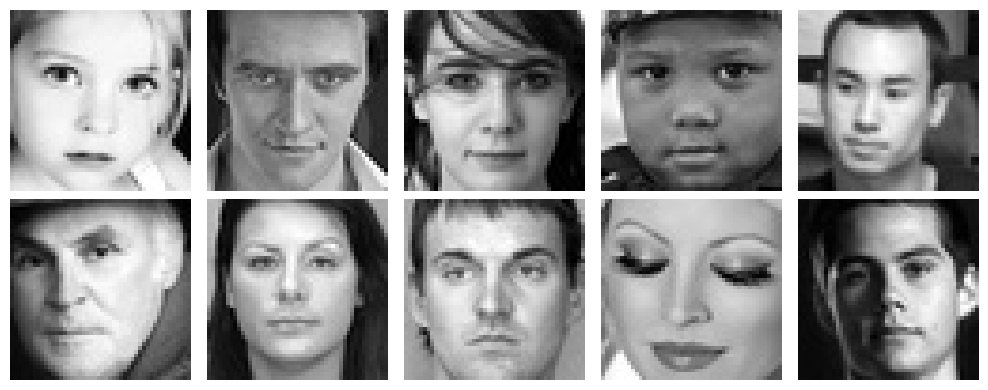

In [ ]:
# Take 10 sample images from the dataset
sample_images = []
for image in dataset.take(10):
    sample_images.append(image[0])  # Assuming each image batch has a shape of (batch_size, height, width, channels)

# Plot the sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*6*cfg.BATCH_SIZE, use_bias=False, input_shape=(cfg.NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((6, 6, cfg.BATCH_SIZE)))
    assert model.output_shape == (None, 6, 6, cfg.BATCH_SIZE)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 48, 1)

    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[48, 48, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
#noisy labels.
def discriminator_loss(real_output, fake_output):
    real_truths = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1, dtype=tf.dtypes.float32, seed=42)
    fake_truths = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0, dtype=tf.dtypes.float32, seed=42)
#     real_loss = cross_entropy(tf.zeros_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    real_loss = cross_entropy(real_truths, real_output)
    fake_loss = cross_entropy(fake_truths, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.zeros_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4)
generator = make_generator_model()
discriminator = make_discriminator_model()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
seed = tf.random.normal([cfg.NUM_EXAMPLES_TO_GENERATE, cfg.NOISE_DIM])


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([cfg.BATCH_SIZE, cfg.NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        print(gen_loss, disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

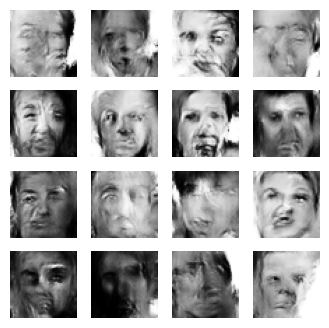

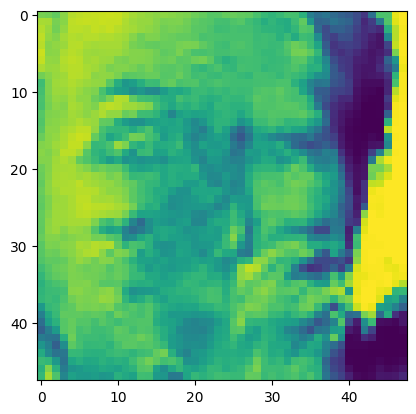

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    predictions = (predictions * 127) + 127

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
tf.config.run_functions_eagerly(True)
train(dataset, cfg.EPOCHS)
im = generator(seed, training=False)
i = (im[0]*127)+127
plt.imshow(i)


In [ ]:
# Save the trained generator model
generator.save('/content/generator_model.h5')


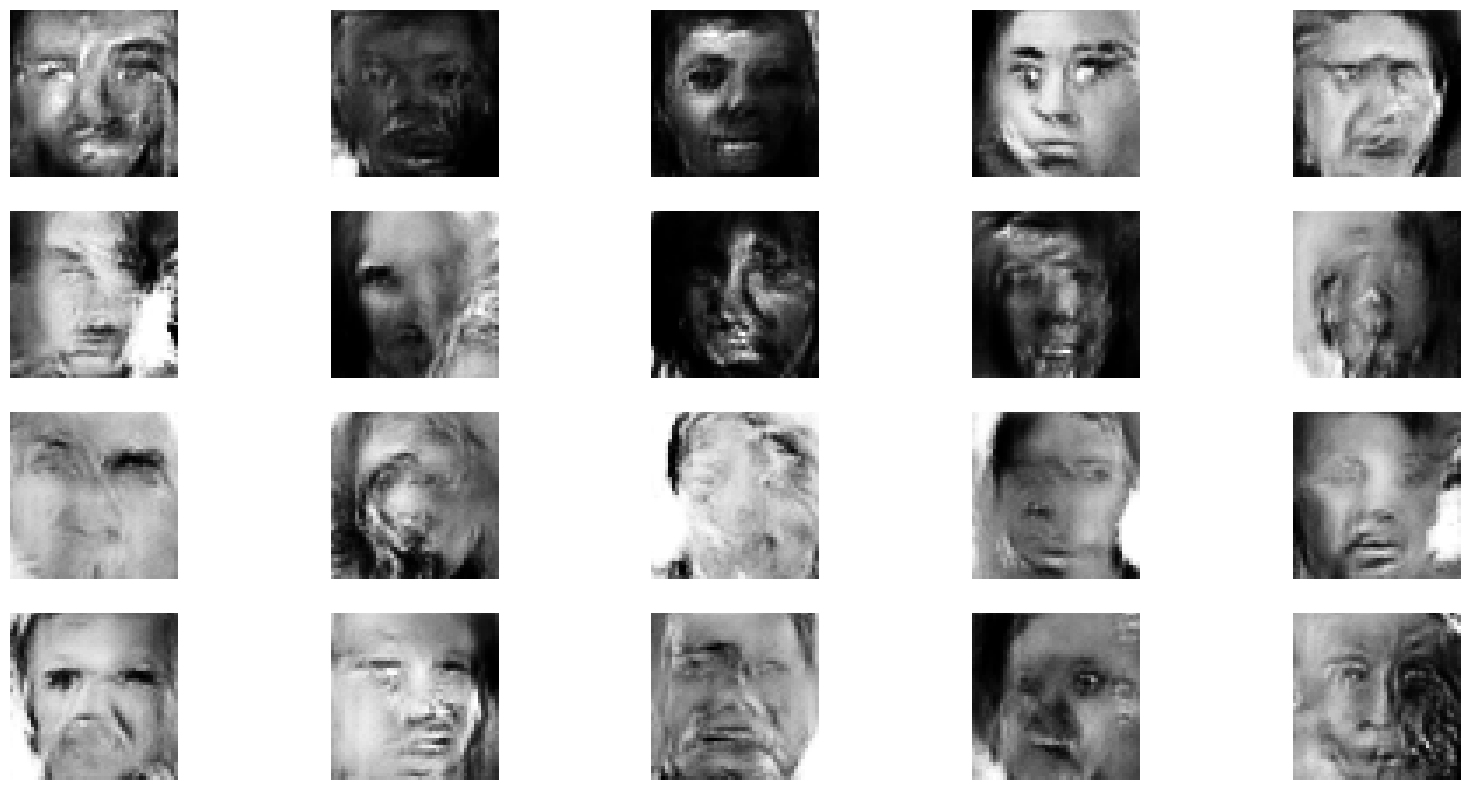

In [ ]:
# Generate 20 random images using the saved model

from tensorflow.keras.models import load_model

# Load the saved model
generator = load_model('/content/generator_model.h5')

# Generate a random seed
seed = tf.random.normal([20, cfg.NOISE_DIM])

# Generate 20 images from the model
images = generator(seed, training=False)

# Scale the images back to the original scale
images = (images * 127.5) + 127.5

# Plot the generated images
fig = plt.figure(figsize=(20, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
